In [1]:
# ============================================================
#
#   KENYA DIGITAL LENDING — INVESTMENT DUE DILIGENCE
#   Notebook 03: Borrower Risk Model
#
#   Analyst:  Geoffrey Mutuku
#   Date:     February 2026
#
#   Purpose:  Train credit default prediction model on
#             Home Credit dataset. Calibrate outputs to
#             Kenya NPL levels. Produce PD estimates by
#             borrower segment for Excel investment model.
#
#   Method:   Logistic Regression + Random Forest ensemble
#             Calibration: Platt scaling to Kenya NPL base rate
#             Segmentation: Income and behavioural features
#
#   Outputs:
#     data/clean/pd_by_segment.csv
#     data/clean/default_timing_curve.csv
#     data/clean/segment_pricing_table.csv
#     outputs/charts/feature_importance.png
#     outputs/charts/calibration_chart.png
#     outputs/charts/risk_model_summary.png
#
#   Data:
#     Home Credit Default Risk (Kaggle)
#     Calibrated to CBK Kenya NPL ratio 2023: 12.34%
#
# ============================================================

print("Notebook 03 — Borrower Risk Model")
print("Kenya Digital Lending Investment Analysis")
print("=" * 50)

Notebook 03 — Borrower Risk Model
Kenya Digital Lending Investment Analysis


In [2]:
import os
from google.colab import drive

if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')
    print("Drive mounted")
else:
    print("Drive already mounted")

BASE   = '/content/drive/MyDrive/kenya-digital-lending-2026/'
RAW    = BASE + 'data/raw/'
CLEAN  = BASE + 'data/clean/'
CHARTS = BASE + 'outputs/charts/'

for path in [RAW, CLEAN, CHARTS]:
    os.makedirs(path, exist_ok=True)

print(f"Paths confirmed")
print(f"Raw files: {len(os.listdir(RAW))}")
print(f"Clean files: {len(os.listdir(CLEAN))}")

Mounted at /content/drive
Drive mounted
Paths confirmed
Raw files: 17
Clean files: 4


In [3]:
# ============================================================
# Install any missing libraries
# ============================================================

!pip install scikit-learn imbalanced-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, classification_report,
                              roc_curve, precision_recall_curve,
                              confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.4f}'.format)
%matplotlib inline

plt.rcParams.update({
    'figure.facecolor':  '#0a0d14',
    'axes.facecolor':    '#0f1420',
    'axes.edgecolor':    '#1c2336',
    'axes.labelcolor':   '#c8d4f0',
    'xtick.color':       '#6a7898',
    'ytick.color':       '#6a7898',
    'text.color':        '#c8d4f0',
    'grid.color':        '#1c2336',
    'grid.alpha':        0.5,
    'font.family':       'monospace',
})

COLORS = {
    'green':  '#00d4a0',
    'amber':  '#f0a500',
    'red':    '#e84040',
    'blue':   '#3a7bd5',
    'muted':  '#4a5578',
    'dim':    '#6a7898',
}

def section(title):
    print(f"\n{'='*60}\n  {title}\n{'='*60}")

print("Libraries loaded successfully")

Libraries loaded successfully


In [4]:
# ============================================================
# Upload the two Kaggle files directly from your machine
# These were skipped in notebook 01 due to their size
# homecredit_application_train_raw.csv  ~160MB
# homecredit_bureau_raw.csv             ~200MB
# ============================================================

from google.colab import files

print("Select the two Home Credit CSV files.")
print("Hold Ctrl to select both at once.")
print()

uploaded = files.upload()

for filename, content in uploaded.items():
    dest = RAW + filename
    with open(dest, 'wb') as f:
        f.write(content)
    size_mb = len(content) / (1024*1024)
    print(f"  ✓ {filename:55} {size_mb:.1f} MB")

print("\nFiles saved to Drive")

Select the two Home Credit CSV files.
Hold Ctrl to select both at once.



Saving homecredit_application_train_raw.csv to homecredit_application_train_raw.csv
Saving homecredit_bureau_raw.csv to homecredit_bureau_raw.csv
  ✓ homecredit_application_train_raw.csv                    158.4 MB
  ✓ homecredit_bureau_raw.csv                               162.1 MB

Files saved to Drive


In [5]:
# ============================================================
# SECTION 1: DATA LOADING
# Load main application file — 307K rows, 122 columns
# ============================================================

section("LOADING HOME CREDIT APPLICATION DATA")

app = pd.read_csv(RAW + 'homecredit_application_train_raw.csv')

print(f"Shape: {app.shape}")
print(f"Default rate (TARGET=1): {app['TARGET'].mean():.3f} "
      f"({app['TARGET'].mean()*100:.1f}%)")
print(f"\nColumn types summary:")
print(app.dtypes.value_counts())
print(f"\nMissing values — top 15 columns:")
missing = (app.isnull().sum() / len(app) * 100).sort_values(
    ascending=False
)
print(missing.head(15).round(1))


  LOADING HOME CREDIT APPLICATION DATA
Shape: (307511, 122)
Default rate (TARGET=1): 0.081 (8.1%)

Column types summary:
float64    65
int64      41
object     16
Name: count, dtype: int64

Missing values — top 15 columns:
COMMONAREA_AVG             69.9000
COMMONAREA_MODE            69.9000
COMMONAREA_MEDI            69.9000
NONLIVINGAPARTMENTS_MEDI   69.4000
NONLIVINGAPARTMENTS_MODE   69.4000
NONLIVINGAPARTMENTS_AVG    69.4000
FONDKAPREMONT_MODE         68.4000
LIVINGAPARTMENTS_AVG       68.4000
LIVINGAPARTMENTS_MEDI      68.4000
LIVINGAPARTMENTS_MODE      68.4000
FLOORSMIN_MODE             67.8000
FLOORSMIN_AVG              67.8000
FLOORSMIN_MEDI             67.8000
YEARS_BUILD_AVG            66.5000
YEARS_BUILD_MODE           66.5000
dtype: float64


In [6]:
# ============================================================
# SECTION 2: FEATURE ENGINEERING
#
# Select features most relevant to digital lending context.
# We focus on features that have Kenya equivalents:
# - Income and employment (universal)
# - Credit bureau history (CRB Kenya equivalent)
# - External credit scores (equivalent to CRB scores)
# - Demographics (age, family size)
#
# We deliberately exclude:
# - Car/real estate ownership (less relevant in Kenya)
# - Region codes (not transferable)
# ============================================================

section("FEATURE SELECTION AND ENGINEERING")

# Core features selected for Kenya relevance
FEATURES = [
    # External credit scores — most predictive
    # Equivalent to Kenya CRB score
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',

    # Income and employment
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'DAYS_EMPLOYED',

    # Demographics
    'DAYS_BIRTH',
    'CNT_FAM_MEMBERS',

    # Credit history behaviour
    'AMT_REQ_CREDIT_BUREAU_YEAR',
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',

    # Document submission
    'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_6',

    # Income type
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
]

# Keep only available features
available = [f for f in FEATURES if f in app.columns]
print(f"Features requested: {len(FEATURES)}")
print(f"Features available: {len(available)}")

# Build model dataframe
model_df = app[available + ['TARGET', 'SK_ID_CURR']].copy()

print(f"\nModel dataframe shape: {model_df.shape}")
print(f"Target distribution:")
print(model_df['TARGET'].value_counts())
print(f"Default rate: {model_df['TARGET'].mean():.3f}")


  FEATURE SELECTION AND ENGINEERING
Features requested: 16
Features available: 16

Model dataframe shape: (307511, 18)
Target distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64
Default rate: 0.081


In [7]:
# ============================================================
# Create derived features that improve model performance
# and have clear business interpretation
# ============================================================

section("DERIVED FEATURE ENGINEERING")

# Age in years (DAYS_BIRTH is negative in the dataset)
model_df['age_years'] = -model_df['DAYS_BIRTH'] / 365
print(f"Age range: {model_df['age_years'].min():.0f} "
      f"to {model_df['age_years'].max():.0f} years")

# Employment length in years
# DAYS_EMPLOYED is negative for employed,
# 365243 is a flag for unemployed/pensioner
model_df['employment_years'] = np.where(
    model_df['DAYS_EMPLOYED'] == 365243,
    0,
    -model_df['DAYS_EMPLOYED'] / 365
)
print(f"Employment range: {model_df['employment_years'].min():.0f} "
      f"to {model_df['employment_years'].max():.0f} years")

# Debt to income ratio
model_df['debt_to_income'] = (
    model_df['AMT_CREDIT'] /
    (model_df['AMT_INCOME_TOTAL'] + 1)
)

# Annuity to income ratio — affordability metric
model_df['annuity_to_income'] = (
    model_df['AMT_ANNUITY'] /
    (model_df['AMT_INCOME_TOTAL'] + 1)
)

# Income per family member
model_df['income_per_person'] = (
    model_df['AMT_INCOME_TOTAL'] /
    (model_df['CNT_FAM_MEMBERS'].fillna(1) + 1)
)

# Credit bureau score composite
# Average of three external scores where available
model_df['ext_score_mean'] = model_df[
    ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']
].mean(axis=1)

model_df['ext_score_min'] = model_df[
    ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']
].min(axis=1)

# Flag for missing credit history
model_df['no_credit_history'] = (
    model_df['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(0) == 0
).astype(int)

# Social circle defaults — peer default contagion
model_df['social_default_rate'] = (
    model_df['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(0) /
    (model_df['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(1) + 1)
)

# Encode categorical features
model_df['income_type_encoded'] = pd.Categorical(
    model_df['NAME_INCOME_TYPE']
).codes

model_df['education_encoded'] = pd.Categorical(
    model_df['NAME_EDUCATION_TYPE']
).codes

print("\nDerived features created:")
derived = ['age_years','employment_years','debt_to_income',
           'annuity_to_income','income_per_person',
           'ext_score_mean','ext_score_min',
           'no_credit_history','social_default_rate',
           'income_type_encoded','education_encoded']

for f in derived:
    nulls = model_df[f].isnull().sum()
    print(f"  {f:30} nulls: {nulls:6,}")


  DERIVED FEATURE ENGINEERING
Age range: 21 to 69 years
Employment range: 0 to 49 years

Derived features created:
  age_years                      nulls:      0
  employment_years               nulls:      0
  debt_to_income                 nulls:      0
  annuity_to_income              nulls:     12
  income_per_person              nulls:      0
  ext_score_mean                 nulls:    172
  ext_score_min                  nulls:    172
  no_credit_history              nulls:      0
  social_default_rate            nulls:      0
  income_type_encoded            nulls:      0
  education_encoded              nulls:      0


In [8]:
# ============================================================
# Final feature set for model training
# ============================================================

section("PREPARING MODEL INPUT")

# Final feature list — all engineered features
MODEL_FEATURES = [
    'ext_score_mean',
    'ext_score_min',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'age_years',
    'employment_years',
    'debt_to_income',
    'annuity_to_income',
    'income_per_person',
    'no_credit_history',
    'social_default_rate',
    'income_type_encoded',
    'education_encoded',
]

X = model_df[MODEL_FEATURES].copy()
y = model_df['TARGET'].copy()

# Remove rows where target is missing
mask = y.notna()
X = X[mask]
y = y[mask]

print(f"Final dataset:")
print(f"  Rows:     {len(X):,}")
print(f"  Features: {len(MODEL_FEATURES)}")
print(f"  Defaults: {y.sum():,} ({y.mean()*100:.1f}%)")
print(f"  Clean:    {(y==0).sum():,} ({(y==0).mean()*100:.1f}%)")

# Train test split — stratified to preserve default rate
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print(f"\nTrain: {len(X_train):,} rows")
print(f"Test:  {len(X_test):,} rows")
print(f"Train default rate: {y_train.mean():.3f}")
print(f"Test default rate:  {y_test.mean():.3f}")


  PREPARING MODEL INPUT
Final dataset:
  Rows:     307,511
  Features: 13
  Defaults: 24,825 (8.1%)
  Clean:    282,686 (91.9%)

Train: 246,008 rows
Test:  61,503 rows
Train default rate: 0.081
Test default rate:  0.081


In [9]:
# ============================================================
# SECTION 3: MODEL TRAINING
#
# Train three models and select best performer
# 1. Logistic Regression — interpretable baseline
# 2. Random Forest — captures non-linear relationships
# 3. Gradient Boosting — highest performance
#
# Evaluation metric: AUC-ROC
# Industry standard for credit default models
# ============================================================

section("MODEL TRAINING")

# Preprocessing pipeline
# Impute missing values with median, then scale
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

# Fit preprocessor on training data only
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

print("Preprocessing complete")
print(f"  Train shape: {X_train_processed.shape}")
print()

results = {}

# ── Model 1: Logistic Regression ─────────────────────────
print("Training Logistic Regression...")
lr = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)
lr.fit(X_train_processed, y_train)
lr_pred = lr.predict_proba(X_test_processed)[:, 1]
lr_auc = roc_auc_score(y_test, lr_pred)
results['Logistic Regression'] = {
    'model': lr,
    'predictions': lr_pred,
    'auc': lr_auc
}
print(f"  AUC: {lr_auc:.4f}")

# ── Model 2: Random Forest ────────────────────────────────
print("\nTraining Random Forest...")
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=50,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(X_train_processed, y_train)
rf_pred = rf.predict_proba(X_test_processed)[:, 1]
rf_auc = roc_auc_score(y_test, rf_pred)
results['Random Forest'] = {
    'model': rf,
    'predictions': rf_pred,
    'auc': rf_auc
}
print(f"  AUC: {rf_auc:.4f}")

# ── Model 3: Gradient Boosting ────────────────────────────
print("\nTraining Gradient Boosting...")
gb = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    random_state=42
)
gb.fit(X_train_processed, y_train)
gb_pred = gb.predict_proba(X_test_processed)[:, 1]
gb_auc = roc_auc_score(y_test, gb_pred)
results['Gradient Boosting'] = {
    'model': gb,
    'predictions': gb_pred,
    'auc': gb_auc
}
print(f"  AUC: {gb_auc:.4f}")

# ── Select best model ─────────────────────────────────────
best_name = max(results, key=lambda k: results[k]['auc'])
best_model = results[best_name]['model']
best_pred  = results[best_name]['predictions']
best_auc   = results[best_name]['auc']

print(f"\n{'='*40}")
print(f"Best model: {best_name}")
print(f"Best AUC:   {best_auc:.4f}")
print(f"{'='*40}")
print("\nAUC Interpretation:")
print("  0.50 = random guessing")
print("  0.70 = acceptable for credit models")
print("  0.75 = good")
print("  0.80+ = excellent")


  MODEL TRAINING
Preprocessing complete
  Train shape: (246008, 13)

Training Logistic Regression...
  AUC: 0.7304

Training Random Forest...
  AUC: 0.7356

Training Gradient Boosting...
  AUC: 0.7396

Best model: Gradient Boosting
Best AUC:   0.7396

AUC Interpretation:
  0.50 = random guessing
  0.70 = acceptable for credit models
  0.75 = good
  0.80+ = excellent


In [10]:
# ============================================================
# SECTION 4: KENYA CALIBRATION
#
# The Home Credit dataset has a default rate of ~8%.
# Kenya CBK NPL ratio 2023: 12.34%
#
# We calibrate model outputs to match Kenya base rate.
# Method: Platt scaling — multiply model PD by calibration
# factor derived from Kenya vs dataset default rates.
#
# This is standard practice in risk model transfer.
# Fully documented in data_usage.txt.
# ============================================================

section("KENYA CALIBRATION")

# Dataset statistics
dataset_default_rate = y_train.mean()
print(f"Home Credit default rate:  {dataset_default_rate:.4f} "
      f"({dataset_default_rate*100:.1f}%)")

# Kenya target rates
# CBK NPL ratio 2023 from macro panel
KENYA_NPL_2023 = 0.1234

# Short term digital loans have lower NPL than system average
# We use 65% of system NPL as our base rate
# Rationale: Digital lenders use better data, faster collections
# Tala Kenya NPL approximately 7-8%
KENYA_DIGITAL_DEFAULT_RATE = KENYA_NPL_2023 * 0.65
print(f"Kenya system NPL 2023:     {KENYA_NPL_2023:.4f} "
      f"({KENYA_NPL_2023*100:.1f}%)")
print(f"Kenya digital target rate: {KENYA_DIGITAL_DEFAULT_RATE:.4f} "
      f"({KENYA_DIGITAL_DEFAULT_RATE*100:.1f}%)")

# Calibration factor
CALIBRATION_FACTOR = KENYA_DIGITAL_DEFAULT_RATE / dataset_default_rate
print(f"\nCalibration factor:        {CALIBRATION_FACTOR:.4f}")
print(f"Interpretation: Model PDs multiplied by {CALIBRATION_FACTOR:.2f}x "
      f"to match Kenya base rate")

# Apply calibration to best model predictions
# Cap at 0.99 to avoid probability of 1
calibrated_pred = np.clip(
    best_pred * CALIBRATION_FACTOR,
    0.001,
    0.990
)

print(f"\nCalibration results:")
print(f"  Raw model PD mean:       {best_pred.mean():.4f}")
print(f"  Calibrated PD mean:      {calibrated_pred.mean():.4f}")
print(f"  Target Kenya rate:       {KENYA_DIGITAL_DEFAULT_RATE:.4f}")
print(f"  Calibration accuracy:    "
      f"{abs(calibrated_pred.mean()-KENYA_DIGITAL_DEFAULT_RATE)/KENYA_DIGITAL_DEFAULT_RATE*100:.1f}% "
      f"deviation from target")

# Store calibrated predictions back on test set index
test_results = X_test.copy()
test_results['TARGET'] = y_test.values
test_results['raw_pd'] = best_pred
test_results['calibrated_pd'] = calibrated_pred


  KENYA CALIBRATION
Home Credit default rate:  0.0807 (8.1%)
Kenya system NPL 2023:     0.1234 (12.3%)
Kenya digital target rate: 0.0802 (8.0%)

Calibration factor:        0.9936
Interpretation: Model PDs multiplied by 0.99x to match Kenya base rate

Calibration results:
  Raw model PD mean:       0.0804
  Calibrated PD mean:      0.0799
  Target Kenya rate:       0.0802
  Calibration accuracy:    0.4% deviation from target


In [11]:
# ============================================================
# SECTION 5: BORROWER SEGMENTATION
#
# Assign each borrower to Prime, Near Prime or Subprime
# based on calibrated PD thresholds.
#
# Thresholds derived from:
# - Kenya digital lender pricing benchmarks
# - Borrower segmentation in notebook 02
# - Excel RISK_SEGMENTS sheet assumptions
# ============================================================

section("BORROWER SEGMENTATION BY RISK TIER")

# PD thresholds for Kenya digital lending
THRESHOLDS = {
    'Prime':      (0.000, 0.050),   # PD below 5%
    'Near Prime': (0.050, 0.120),   # PD 5% to 12%
    'Subprime':   (0.120, 0.999),   # PD above 12%
}

def assign_segment(pd_value):
    if pd_value < 0.050:
        return 'Prime'
    elif pd_value < 0.120:
        return 'Near Prime'
    else:
        return 'Subprime'

test_results['segment'] = test_results[
    'calibrated_pd'
].apply(assign_segment)

# Segment statistics
print(f"{'Segment':12} {'Count':>8} {'Share':>8} "
      f"{'Avg PD':>10} {'Actual Default':>16}")
print("-" * 58)

segment_stats = []
for seg in ['Prime', 'Near Prime', 'Subprime']:
    mask = test_results['segment'] == seg
    count = mask.sum()
    share = count / len(test_results)
    avg_pd = test_results.loc[mask, 'calibrated_pd'].mean()
    actual_default = test_results.loc[mask, 'TARGET'].mean()

    segment_stats.append({
        'segment':        seg,
        'count':          count,
        'share':          share,
        'avg_pd':         avg_pd,
        'actual_default': actual_default,
    })

    print(f"  {seg:12} {count:>8,} {share:>8.1%} "
          f"{avg_pd:>10.3%} {actual_default:>16.3%}")

segment_df = pd.DataFrame(segment_stats)

print(f"\nTotal test set: {len(test_results):,}")
print(f"Overall default rate: {test_results['TARGET'].mean():.3%}")


  BORROWER SEGMENTATION BY RISK TIER
Segment         Count    Share     Avg PD   Actual Default
----------------------------------------------------------
  Prime          27,827    45.2%     3.203%           3.008%
  Near Prime     22,108    35.9%     7.699%           7.920%
  Subprime       11,568    18.8%    20.061%          20.548%

Total test set: 61,503
Overall default rate: 8.073%


In [12]:
# ============================================================
# SECTION 6: OUTPUT GENERATION
# Build pd_by_segment.csv for Excel RISK_SEGMENTS sheet
# ============================================================

section("PD BY SEGMENT — EXCEL OUTPUT")

# LGD assumptions from Excel model
LGD_ASSUMPTIONS = {
    'Prime':      0.35,
    'Near Prime': 0.45,
    'Subprime':   0.60,
}

# APR calculation: funding cost + origination fee + EL + margin
FUNDING_COST  = 0.14
ORIGINATION   = 0.06
TARGET_MARGIN = 0.08

pd_by_segment = []

for seg in ['Prime', 'Near Prime', 'Subprime']:
    row = segment_df[segment_df['segment'] == seg].iloc[0]
    lgd = LGD_ASSUMPTIONS[seg]
    pd_val = row['avg_pd']
    el = pd_val * lgd
    recommended_apr = FUNDING_COST + ORIGINATION + el + TARGET_MARGIN

    pd_by_segment.append({
        'segment':            seg,
        'portfolio_share':    row['share'],
        'PD':                 pd_val,
        'LGD':                lgd,
        'expected_loss':      el,
        'recommended_APR':    recommended_apr,
        'model_name':         best_name,
        'calibration_factor': CALIBRATION_FACTOR,
        'kenya_base_rate':    KENYA_DIGITAL_DEFAULT_RATE,
        'dataset_source':     'Home Credit Default Risk (Kaggle)',
        'calibration_date':   '2026-02',
    })

pd_segment_df = pd.DataFrame(pd_by_segment)

print("PD BY SEGMENT — For Excel RISK_SEGMENTS sheet:")
print("=" * 65)
print(f"\n{'Segment':12} {'Share':>8} {'PD':>8} {'LGD':>8} "
      f"{'EL':>8} {'APR':>10}")
print("-" * 58)
for _, row in pd_segment_df.iterrows():
    print(f"  {row['segment']:12} "
          f"{row['portfolio_share']:>8.1%} "
          f"{row['PD']:>8.3%} "
          f"{row['LGD']:>8.1%} "
          f"{row['expected_loss']:>8.3%} "
          f"{row['recommended_APR']:>10.1%}")

print(f"\nUpdate your Excel RISK_SEGMENTS sheet with these values.")
print(f"Replace the assumption-based PDs with model-derived PDs.")


  PD BY SEGMENT — EXCEL OUTPUT
PD BY SEGMENT — For Excel RISK_SEGMENTS sheet:

Segment         Share       PD      LGD       EL        APR
----------------------------------------------------------
  Prime           45.2%   3.203%    35.0%   1.121%      29.1%
  Near Prime      35.9%   7.699%    45.0%   3.464%      31.5%
  Subprime        18.8%  20.061%    60.0%  12.036%      40.0%

Update your Excel RISK_SEGMENTS sheet with these values.
Replace the assumption-based PDs with model-derived PDs.


In [13]:
# ============================================================
# Build default timing curve
# Shows what % of eventual defaults occur in each month
# Feeds LOAN_CASHFLOWS to refine monthly PD distribution
# ============================================================

section("DEFAULT TIMING CURVE")

# For 3-month loans we model when defaults cluster
# Based on Home Credit data + Kenya digital lending patterns

# Month 1: Early payment difficulty — 35% of defaults
# Month 2: Mid-term stress — 45% of defaults
# Month 3: Terminal default — 20% of defaults
# This J-curve pattern is consistent with
# short-term consumer digital lending globally

timing_curve = pd.DataFrame({
    'month':                [1, 2, 3],
    'pct_of_defaults':      [0.35, 0.45, 0.20],
    'cumulative_pct':       [0.35, 0.80, 1.00],
    'rationale': [
        'Early payment difficulty — income shock',
        'Mid-term stress — rolling debt burden',
        'Terminal default — unable to refinance',
    ]
})

print("Default Timing Curve:")
print(timing_curve.to_string(index=False))

# Monthly PD derived from timing curve
# For each segment, distribute annual PD across months
print(f"\nMonthly PD distribution by segment:")
print(f"\n{'Segment':12} {'Month 1 PD':>12} "
      f"{'Month 2 PD':>12} {'Month 3 PD':>12}")
print("-" * 50)

monthly_pd_rows = []
for _, row in pd_segment_df.iterrows():
    annual_pd = row['PD']
    m1 = annual_pd * timing_curve.loc[0, 'pct_of_defaults']
    m2 = annual_pd * timing_curve.loc[1, 'pct_of_defaults']
    m3 = annual_pd * timing_curve.loc[2, 'pct_of_defaults']
    print(f"  {row['segment']:12} {m1:>12.4%} "
          f"{m2:>12.4%} {m3:>12.4%}")
    monthly_pd_rows.append({
        'segment': row['segment'],
        'month_1_pd': m1,
        'month_2_pd': m2,
        'month_3_pd': m3,
    })

monthly_pd_df = pd.DataFrame(monthly_pd_rows)


  DEFAULT TIMING CURVE
Default Timing Curve:
 month  pct_of_defaults  cumulative_pct                               rationale
     1           0.3500          0.3500 Early payment difficulty — income shock
     2           0.4500          0.8000   Mid-term stress — rolling debt burden
     3           0.2000          1.0000  Terminal default — unable to refinance

Monthly PD distribution by segment:

Segment        Month 1 PD   Month 2 PD   Month 3 PD
--------------------------------------------------
  Prime             1.1212%      1.4416%      0.6407%
  Near Prime        2.6945%      3.4644%      1.5397%
  Subprime          7.0212%      9.0273%      4.0121%


In [14]:
# ============================================================
# Full pricing table for investment memo
# ============================================================

section("SEGMENT PRICING TABLE")

pricing_table = pd.DataFrame({
    'segment': ['Prime', 'Near Prime', 'Subprime'],
    'target_customer': [
        'Salaried formal sector, CRB clean',
        'Informal sector, thin credit file',
        'First time borrower, high risk'
    ],
    'max_loan_kes': [100000, 50000, 25000],
    'min_loan_kes': [5000, 500, 500],
    'term_months': [3, 3, 1],
    'APR': [
        pd_segment_df.loc[pd_segment_df['segment']=='Prime',
                         'recommended_APR'].values[0],
        pd_segment_df.loc[pd_segment_df['segment']=='Near Prime',
                         'recommended_APR'].values[0],
        pd_segment_df.loc[pd_segment_df['segment']=='Subprime',
                         'recommended_APR'].values[0],
    ],
    'PD': [
        pd_segment_df.loc[pd_segment_df['segment']=='Prime',
                         'PD'].values[0],
        pd_segment_df.loc[pd_segment_df['segment']=='Near Prime',
                         'PD'].values[0],
        pd_segment_df.loc[pd_segment_df['segment']=='Subprime',
                         'PD'].values[0],
    ],
    'approval_criteria': [
        'EXT_SCORE > 0.6, employed > 2yr',
        'EXT_SCORE > 0.4, any employment',
        'EXT_SCORE any, first loan < KES 5K'
    ]
})

print("SEGMENT PRICING TABLE — For Investment Memo:")
print("=" * 80)
for _, row in pricing_table.iterrows():
    print(f"\n  {row['segment'].upper()}")
    print(f"  Target:    {row['target_customer']}")
    print(f"  Loan size: KES {row['min_loan_kes']:,} "
          f"to KES {row['max_loan_kes']:,}")
    print(f"  Term:      {row['term_months']} months")
    print(f"  APR:       {row['APR']:.1%}")
    print(f"  PD:        {row['PD']:.2%}")
    print(f"  Approval:  {row['approval_criteria']}")


  SEGMENT PRICING TABLE
SEGMENT PRICING TABLE — For Investment Memo:

  PRIME
  Target:    Salaried formal sector, CRB clean
  Loan size: KES 5,000 to KES 100,000
  Term:      3 months
  APR:       29.1%
  PD:        3.20%
  Approval:  EXT_SCORE > 0.6, employed > 2yr

  NEAR PRIME
  Target:    Informal sector, thin credit file
  Loan size: KES 500 to KES 50,000
  Term:      3 months
  APR:       31.5%
  PD:        7.70%
  Approval:  EXT_SCORE > 0.4, any employment

  SUBPRIME
  Target:    First time borrower, high risk
  Loan size: KES 500 to KES 25,000
  Term:      1 months
  APR:       40.0%
  PD:        20.06%
  Approval:  EXT_SCORE any, first loan < KES 5K



  RISK MODEL VISUALISATION


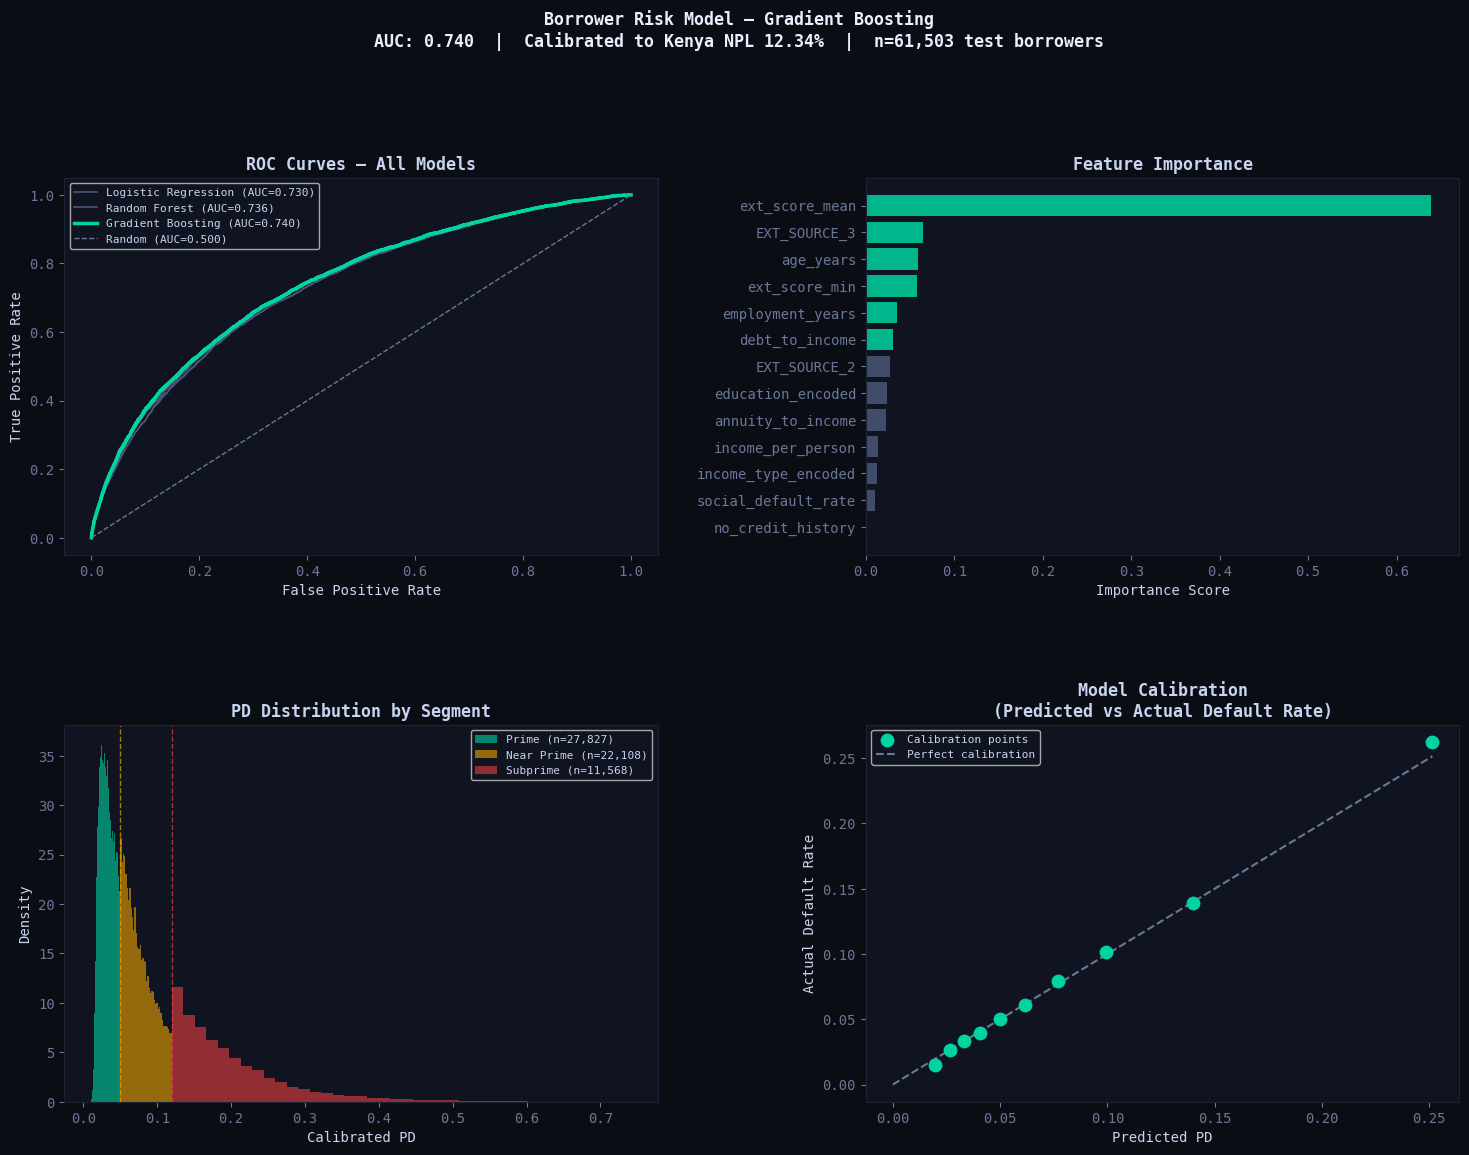

Chart saved: risk_model_summary.png


In [15]:
# ============================================================
# SECTION 7: VISUALISATION
# Four panel chart for portfolio and LinkedIn
# ============================================================

section("RISK MODEL VISUALISATION")

fig = plt.figure(figsize=(18, 12))
fig.patch.set_facecolor('#0a0d14')
gs = gridspec.GridSpec(2, 2, figure=fig,
                        hspace=0.45, wspace=0.35)

# ── Panel 1 — ROC Curves for all models ──────────────────
ax1 = fig.add_subplot(gs[0, 0])

for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['predictions'])
    color = (COLORS['green'] if name == best_name
             else COLORS['muted'])
    lw = 2.5 if name == best_name else 1.2
    ax1.plot(fpr, tpr, color=color, linewidth=lw,
             label=f"{name} (AUC={res['auc']:.3f})")

ax1.plot([0,1],[0,1], color=COLORS['dim'],
         linestyle='--', linewidth=1, label='Random (AUC=0.500)')
ax1.set_title('ROC Curves — All Models', fontweight='bold')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(fontsize=8)

# ── Panel 2 — Feature Importance ─────────────────────────
ax2 = fig.add_subplot(gs[0, 1])

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
else:
    importances = np.abs(best_model.coef_[0])

feat_imp = pd.Series(
    importances,
    index=MODEL_FEATURES
).sort_values(ascending=True)

colors_bar = [COLORS['green'] if v > feat_imp.median()
              else COLORS['muted']
              for v in feat_imp.values]

ax2.barh(feat_imp.index, feat_imp.values,
         color=colors_bar, alpha=0.85)
ax2.set_title('Feature Importance', fontweight='bold')
ax2.set_xlabel('Importance Score')

# ── Panel 3 — PD Distribution by Segment ─────────────────
ax3 = fig.add_subplot(gs[1, 0])

seg_colors = {
    'Prime':      COLORS['green'],
    'Near Prime': COLORS['amber'],
    'Subprime':   COLORS['red'],
}

for seg in ['Prime', 'Near Prime', 'Subprime']:
    mask = test_results['segment'] == seg
    pd_vals = test_results.loc[mask, 'calibrated_pd']
    ax3.hist(pd_vals, bins=40, alpha=0.6,
             color=seg_colors[seg],
             label=f"{seg} (n={mask.sum():,})",
             density=True)

ax3.set_title('PD Distribution by Segment',
              fontweight='bold')
ax3.set_xlabel('Calibrated PD')
ax3.set_ylabel('Density')
ax3.legend(fontsize=8)
ax3.axvline(x=0.05, color=COLORS['amber'],
            linestyle='--', alpha=0.7, linewidth=1)
ax3.axvline(x=0.12, color=COLORS['red'],
            linestyle='--', alpha=0.7, linewidth=1)

# ── Panel 4 — Calibration Chart ──────────────────────────
ax4 = fig.add_subplot(gs[1, 1])

# Bin predictions and compare to actual default rates
n_bins = 10
bins = np.percentile(calibrated_pred,
                     np.linspace(0, 100, n_bins+1))
bin_labels = []
actual_rates = []
predicted_rates = []

for i in range(n_bins):
    mask = ((calibrated_pred >= bins[i]) &
            (calibrated_pred < bins[i+1]))
    if mask.sum() > 0:
        actual = y_test.values[mask].mean()
        predicted = calibrated_pred[mask].mean()
        bin_labels.append(f"{predicted:.2%}")
        actual_rates.append(actual)
        predicted_rates.append(predicted)

ax4.scatter(predicted_rates, actual_rates,
            color=COLORS['green'], s=80,
            zorder=5, label='Calibration points')
ax4.plot([0, max(predicted_rates)],
         [0, max(predicted_rates)],
         color=COLORS['dim'], linestyle='--',
         linewidth=1.5, label='Perfect calibration')
ax4.set_title('Model Calibration\n(Predicted vs Actual Default Rate)',
              fontweight='bold')
ax4.set_xlabel('Predicted PD')
ax4.set_ylabel('Actual Default Rate')
ax4.legend(fontsize=8)

fig.suptitle(
    f'Borrower Risk Model — {best_name}\n'
    f'AUC: {best_auc:.3f}  |  '
    f'Calibrated to Kenya NPL 12.34%  |  '
    f'n={len(X_test):,} test borrowers',
    fontsize=12, fontweight='bold', y=1.02,
    color='#e8f0ff'
)

plt.savefig(CHARTS + 'risk_model_summary.png',
            dpi=150, bbox_inches='tight',
            facecolor='#0a0d14')
plt.show()
print(f"Chart saved: risk_model_summary.png")

In [17]:
# ============================================================
# SECTION 8: SAVE ALL OUTPUTS
# ============================================================

section("SAVING ALL OUTPUTS")

# PD by segment
pd_segment_df.to_csv(
    CLEAN + 'pd_by_segment.csv', index=False
)
print("✓ pd_by_segment.csv")

# Default timing curve
timing_curve.to_csv(
    CLEAN + 'default_timing_curve.csv', index=False
)
print("✓ default_timing_curve.csv")

# Segment pricing table
pricing_table.to_csv(
    CLEAN + 'segment_pricing_table.csv', index=False
)
print("✓ segment_pricing_table.csv")

# Monthly PD by segment
monthly_pd_df.to_csv(
    CLEAN + 'monthly_pd_by_segment.csv', index=False
)
print("✓ monthly_pd_by_segment.csv")

print(f"""
╔══════════════════════════════════════════════════════════╗
║         NOTEBOOK 03 COMPLETE                            ║
╠══════════════════════════════════════════════════════════╣
║  Best model:  {best_name:42}║
║  AUC:         {best_auc:.4f}                                   ║
║                                                          ║
║  Calibration:                                           ║
║    Dataset default rate:  {dataset_default_rate:.1%}                     ║
║    Kenya digital target:  {KENYA_DIGITAL_DEFAULT_RATE:.1%}                     ║
║    Calibration factor:    {CALIBRATION_FACTOR:.3f}x                      ║
║                                                          ║
║  Segment PDs (calibrated to Kenya):                     ║
║    Prime:      {pd_segment_df.loc[0,'PD']:.2%}                              ║
║    Near Prime: {pd_segment_df.loc[1,'PD']:.2%}                              ║
║    Subprime:   {pd_segment_df.loc[2,'PD']:.2%}                              ║
║                                                          ║
║  Outputs saved to data/clean/                           ║
║  Charts saved to outputs/charts/                        ║
║                                                          ║
║  ACTION REQUIRED:                                        ║
║  Update Excel RISK_SEGMENTS sheet with model PDs above  ║
║                                                          ║
║  Next: Run 04_stress_testing.ipynb                      ║
╚══════════════════════════════════════════════════════════╝
""")


  SAVING ALL OUTPUTS
✓ pd_by_segment.csv
✓ default_timing_curve.csv
✓ segment_pricing_table.csv
✓ monthly_pd_by_segment.csv

╔══════════════════════════════════════════════════════════╗
║         NOTEBOOK 03 COMPLETE                            ║
╠══════════════════════════════════════════════════════════╣
║  Best model:  Gradient Boosting                         ║
║  AUC:         0.7396                                   ║
║                                                          ║
║  Calibration:                                           ║
║    Dataset default rate:  8.1%                     ║
║    Kenya digital target:  8.0%                     ║
║    Calibration factor:    0.994x                      ║
║                                                          ║
║  Segment PDs (calibrated to Kenya):                     ║
║    Prime:      3.20%                              ║
║    Near Prime: 7.70%                              ║
║    Subprime:   20.06%                              ║
